In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
# %cd CD_Circuit/

import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
import operator

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals, compare_same
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from pyfunctions.wrappers import Node, AblationSet

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loaded pretrained model gpt2-small into HookedTransformer


## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [4]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=3, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
mean_acts = torch.mean(attention_outputs, dim=0)
old_shape = mean_acts.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
mean_acts = mean_acts.view(new_shape)
mean_acts.shape

2024-09-18 22:18:59.754606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 22:19:02.585829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([12, 16, 768])

In [5]:

# source_list = [Node(0, 0, 0), Node(1, 1, 1)]
# target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
# out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

## Algorithm A (the one found in the current paper)

### Run on last sequence position specifically

In [6]:
import functools
ranges = [
        [layer for layer in range(12)],
        [input_shape[1] - 2],
        # [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]

# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

NameError: name 'old_shape' is not defined

### Ablate all heads at once

In [34]:
import functools
'''
ranges = [
        [layer for layer in range(12)],
        # [input_shape[1] - 2],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]
'''
ablation_sets = []
for layer in range(12):
    for seq_idx in range(15):
        ablation_sets.append(tuple(Node(layer, seq_idx, x) for x in range(12)))
# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

Running inputs 0 to 64 (of 180)
Running inputs 64 to 128 (of 180)
Running inputs 128 to 180 (of 180)


### Do the normal thing and ablate at all individual spots

In [22]:
import functools

ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]

# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

Running inputs 0 to 64 (of 2304)
Running inputs 64 to 128 (of 2304)
Running inputs 128 to 192 (of 2304)
Running inputs 192 to 256 (of 2304)
Running inputs 256 to 320 (of 2304)
Running inputs 320 to 384 (of 2304)
Running inputs 384 to 448 (of 2304)
Running inputs 448 to 512 (of 2304)
Running inputs 512 to 576 (of 2304)
Running inputs 576 to 640 (of 2304)
Running inputs 640 to 704 (of 2304)
Running inputs 704 to 768 (of 2304)
Running inputs 768 to 832 (of 2304)
Running inputs 832 to 896 (of 2304)
Running inputs 896 to 960 (of 2304)
Running inputs 960 to 1024 (of 2304)
Running inputs 1024 to 1088 (of 2304)
Running inputs 1088 to 1152 (of 2304)
Running inputs 1152 to 1216 (of 2304)
Running inputs 1216 to 1280 (of 2304)
Running inputs 1280 to 1344 (of 2304)
Running inputs 1344 to 1408 (of 2304)
Running inputs 1408 to 1472 (of 2304)
Running inputs 1472 to 1536 (of 2304)
Running inputs 1536 to 1600 (of 2304)
Running inputs 1600 to 1664 (of 2304)
Running inputs 1664 to 1728 (of 2304)
Running i

In [23]:
# for each source node determine the contribution of rel to the actual score

logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
full_score = np.abs(io_logit - s_logit)
assert(full_score > 0)

results = []
Result = collections.namedtuple('Result', ('ablation_set', 'score'))

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    #print(score, rel_io_logit, rel_s_logit)
    norm_score = score / full_score
    results.append(Result(decomp.ablation_set, norm_score))


In [111]:
len(out_decomps)

2304

In [ ]:
# Try to add a normalization for layers

In [16]:
print(out_decomps[].ablation_set[0])

Node(layer_idx=0, sequence_idx=0, attn_head_idx=0)


In [26]:
# for each source node determine the contribution of rel to the actual score
# norms_per_layer = np.zeros()
norms = []
for decomp in out_decomps:
    norms.append(np.linalg.norm(decomp.rel))
    
norms_by_layer = np.array(norms).reshape(-1, 16 * 12)
avg_norm_by_layer = np.mean(norms_by_layer, axis=1)

'''
logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
full_score = np.abs(io_logit - s_logit)
assert(full_score > 0)

results = []

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    #print(score, rel_io_logit, rel_s_logit)
    norm_score = score / full_score
    results.append(Result(decomp.ablation_set, norm_score))
'''


'\nlogits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab\nio_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]\ns_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]\nfull_score = np.abs(io_logit - s_logit)\nassert(full_score > 0)\n\nresults = []\n\nfor decomp in out_decomps:\n    rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]\n    rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]\n    score = rel_io_logit - rel_s_logit\n    #print(score, rel_io_logit, rel_s_logit)\n    norm_score = score / full_score\n    results.append(Result(decomp.ablation_set, norm_score))\n'

In [14]:
norms_by_layer.shape

(192, 12)

In [28]:
avg_norm_by_layer

array([219.33165 , 158.0396  , 124.05173 , 100.218346,  79.22871 ,
        63.552044,  52.917133,  38.92066 ,  30.557709,  24.813934,
        18.621202,  11.463805], dtype=float32)

In [24]:

results.sort(key=operator.attrgetter('score'), reverse=True)

In [25]:
results[:30]

[Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=6),), score=0.34177423),
 Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=0),), score=0.28064322),
 Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=9),), score=0.24171533),
 Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=10),), score=0.16338332),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=3),), score=0.1422774),
 Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=2),), score=0.13067995),
 Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=2),), score=0.094204046),
 Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=6),), score=0.0845308),
 Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=1),), score=0.07160555),
 Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=1),), score=0.06859626),
 Result(ablation_set=(Node(layer_id

In [21]:
logits, cache = model.run_with_cache(encoding_idxs[0:1, :])

model_out = out_decomps[0].rel + out_decomps[0].irrel
print(model_out.shape)
compare_same(logits[0], model_out)

(1, 16, 50257)
0.05% of the values are equal


0.00048127624012575364

In [120]:
print(ioi_dataset.sentences[0])

Then, Samantha and Laura went to the school. Samantha gave a computer to Laura


In [115]:
'''
for result in results[:20]:
    print(result.ablation_set[0], result.score)
'''
'''
for result in results:
    if result.ablation_set[0].layer_idx == 9 and result.ablation_set[0].attn_head_idx == 9:
        print(result.ablation_set[0], result.score)
'''
for result in results:
    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or \
        result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:
            print(result.ablation_set[0], result.score)


Node(layer_idx=8, sequence_idx=14, attn_head_idx=6) 0.12152111
Node(layer_idx=8, sequence_idx=14, attn_head_idx=10) 0.0822009
Node(layer_idx=7, sequence_idx=14, attn_head_idx=9) 0.07783296
Node(layer_idx=8, sequence_idx=4, attn_head_idx=10) 0.07362208
Node(layer_idx=7, sequence_idx=4, attn_head_idx=3) 0.071159504
Node(layer_idx=7, sequence_idx=3, attn_head_idx=3) 0.07108998
Node(layer_idx=7, sequence_idx=4, attn_head_idx=9) 0.06943682
Node(layer_idx=7, sequence_idx=3, attn_head_idx=9) 0.06770895
Node(layer_idx=7, sequence_idx=1, attn_head_idx=9) 0.06574008
Node(layer_idx=8, sequence_idx=4, attn_head_idx=6) 0.06536073
Node(layer_idx=7, sequence_idx=1, attn_head_idx=3) 0.06427851
Node(layer_idx=7, sequence_idx=2, attn_head_idx=9) 0.0599772
Node(layer_idx=7, sequence_idx=2, attn_head_idx=3) 0.057893638
Node(layer_idx=8, sequence_idx=2, attn_head_idx=10) 0.057380237
Node(layer_idx=8, sequence_idx=9, attn_head_idx=10) 0.0559245
Node(layer_idx=8, sequence_idx=2, attn_head_idx=6) 0.055904876


In [119]:
scores = [r.score for r in results if r.score > 0]
std_dev = np.std(scores)
mean = np.mean(scores)
print(std_dev, mean)

0.03560574 0.05491805


Text(0.5, 0, 'Contribution')

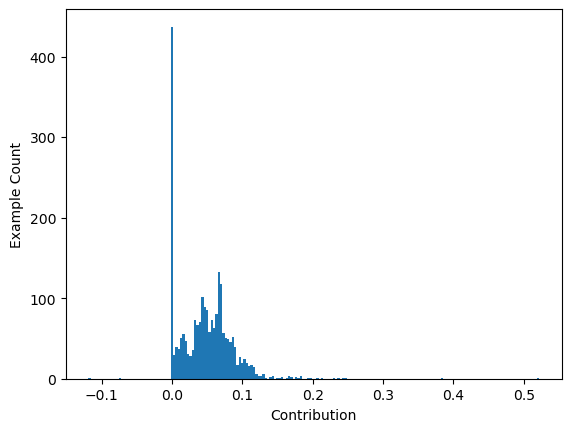

In [116]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=False, bins=192)
plt.ylabel('Example Count')
plt.xlabel('Contribution')

Text(0.5, 0, 'Contribution')

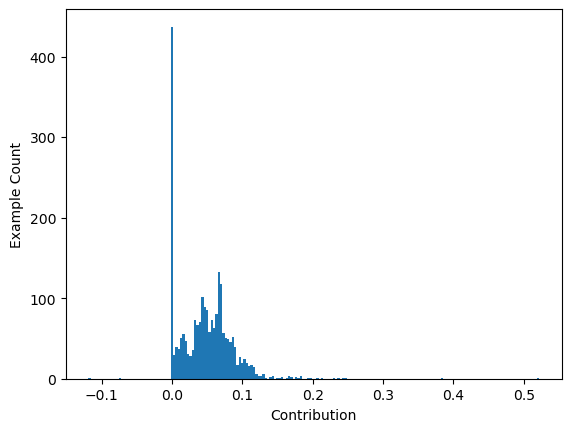

In [116]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=False, bins=192)
plt.ylabel('Example Count')
plt.xlabel('Contribution')

In [23]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):] #bisect does a binary search, returns idx of outlier_score
    return outliers




In [27]:
print(torch.cuda.memory_allocated(0)/1024/1024)
print(torch.cuda.memory_reserved(0)/1024/1024)
import gc
gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0)/1024/1024)
print(torch.cuda.memory_reserved(0)/1024/1024)



11498.65576171875
12060.0
882.81982421875
1212.0


In [19]:
# ioi_dataset.word_idx

In [30]:
outliers_per_iter = []
copy_results = results


In [ ]:
mean_acts_per_head = mean_acts.view(old_shape)
print(mean_acts_per_head.shape)
print(target_decomps[0].rels[0].shape)

torch.Size([12, 16, 12, 64])
torch.Size([1, 64])


In [41]:

ioi_logits, ioi_cache = model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension


In [ ]:
ioi_cache['blocks.' + '0' + '.attn.hook_z'][0][0][0].shape

torch.Size([64])

In [42]:
results = []
for target_decomp in target_decomps:
    # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
    score = 0
    for i, target_node in enumerate(target_decomp.target_nodes):
        target_mean_act = mean_acts[target_node.layer_idx, target_node.sequence_idx, target_node.attn_head_idx]
        target_rel = ioi_cache['blocks.' + str(target_node.layer_idx) + '.attn.hook_z'][0][target_node.sequence_idx][target_node.attn_head_idx] - target_mean_act 
        rel = target_decomp.rels[i][0]
        #print(target_rel.shape, rel.shape)
        score += torch.dot(rel, target_rel)
    results.append(Result(target_decomp.ablation_set, score))
    

In [44]:
results.sort(key=operator.attrgetter('score'), reverse=True)
results[:50]
for result in results:
    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or \
        result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:
        print(result.ablation_set[0], result.score)


Node(layer_idx=7, sequence_idx=2, attn_head_idx=3) tensor(2.8631, device='cuda:0')
Node(layer_idx=7, sequence_idx=2, attn_head_idx=9) tensor(2.5057, device='cuda:0')
Node(layer_idx=8, sequence_idx=2, attn_head_idx=10) tensor(2.3456, device='cuda:0')
Node(layer_idx=7, sequence_idx=3, attn_head_idx=3) tensor(2.1374, device='cuda:0')
Node(layer_idx=8, sequence_idx=14, attn_head_idx=6) tensor(2.0232, device='cuda:0')
Node(layer_idx=7, sequence_idx=14, attn_head_idx=9) tensor(1.5772, device='cuda:0')
Node(layer_idx=8, sequence_idx=10, attn_head_idx=10) tensor(1.5526, device='cuda:0')
Node(layer_idx=8, sequence_idx=14, attn_head_idx=10) tensor(1.4639, device='cuda:0')
Node(layer_idx=7, sequence_idx=3, attn_head_idx=9) tensor(1.2003, device='cuda:0')
Node(layer_idx=8, sequence_idx=2, attn_head_idx=6) tensor(1.1704, device='cuda:0')
Node(layer_idx=8, sequence_idx=10, attn_head_idx=6) tensor(1.1144, device='cuda:0')
Node(layer_idx=7, sequence_idx=11, attn_head_idx=9) tensor(0.9955, device='cuda

In [35]:
# Now, find maximally relevant source nodes to target nodes

# TODO: this needs to be put in a loop to implement the "actual" algorithm, currently it's just for analysis
# results.sort(key=operator.attrgetter('score'), reverse=False)|
# iqr = interquartile_range(results)
# print(len(iqr))
# outliers = n_sigma_rule(results, n=0.5)
# print(len(outliers))

results.sort(key=operator.attrgetter('score'), reverse=True)
outliers = copy_results[:3] # hardcoded first few N
outliers_per_iter.append(outliers)
target_nodes = [r.ablation_set[0] for r in outliers] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else
print(target_nodes)
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(16)],
        # [ioi_dataset.word_idx['IO'][0]],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

results = []
for target_decomp in target_decomps:
    # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
    score = 0
    for i in range(len(target_decomp.target_nodes)):
        rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
        irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
        target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
        score += target_node_score
    results.append(Result(target_decomp.ablation_set, score))

results.sort(key=operator.attrgetter('score'), reverse=True)
print(results[:15])

[Node(layer_idx=9, sequence_idx=14, attn_head_idx=6), Node(layer_idx=10, sequence_idx=14, attn_head_idx=0), Node(layer_idx=9, sequence_idx=14, attn_head_idx=9)]
Running inputs 0 to 64 (of 2304)
Running inputs 64 to 128 (of 2304)
Running inputs 128 to 192 (of 2304)
Running inputs 192 to 256 (of 2304)
Running inputs 256 to 320 (of 2304)
Running inputs 320 to 384 (of 2304)
Running inputs 384 to 448 (of 2304)
Running inputs 448 to 512 (of 2304)
Running inputs 512 to 576 (of 2304)
Running inputs 576 to 640 (of 2304)
Running inputs 640 to 704 (of 2304)
Running inputs 704 to 768 (of 2304)
Running inputs 768 to 832 (of 2304)
Running inputs 832 to 896 (of 2304)
Running inputs 896 to 960 (of 2304)
Running inputs 960 to 1024 (of 2304)
Running inputs 1024 to 1088 (of 2304)
Running inputs 1088 to 1152 (of 2304)
Running inputs 1152 to 1216 (of 2304)
Running inputs 1216 to 1280 (of 2304)
Running inputs 1280 to 1344 (of 2304)
Running inputs 1344 to 1408 (of 2304)
Running inputs 1408 to 1472 (of 2304)


In [39]:
'''
for result in results[:20]:
    print(result)
'''
for result in results:
    if result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 9 or \
        result.ablation_set[0].layer_idx == 7 and result.ablation_set[0].attn_head_idx == 3 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 6 or \
        result.ablation_set[0].layer_idx == 8 and result.ablation_set[0].attn_head_idx == 10:
        print(result.ablation_set[0], result.score)


Node(layer_idx=7, sequence_idx=3, attn_head_idx=9) tensor(0.0242, device='cuda:0')
Node(layer_idx=7, sequence_idx=14, attn_head_idx=9) tensor(0.0228, device='cuda:0')
Node(layer_idx=8, sequence_idx=14, attn_head_idx=10) tensor(0.0218, device='cuda:0')
Node(layer_idx=7, sequence_idx=3, attn_head_idx=3) tensor(0.0216, device='cuda:0')
Node(layer_idx=8, sequence_idx=14, attn_head_idx=6) tensor(0.0204, device='cuda:0')
Node(layer_idx=7, sequence_idx=11, attn_head_idx=9) tensor(0.0197, device='cuda:0')
Node(layer_idx=8, sequence_idx=3, attn_head_idx=6) tensor(0.0185, device='cuda:0')
Node(layer_idx=8, sequence_idx=11, attn_head_idx=10) tensor(0.0180, device='cuda:0')
Node(layer_idx=8, sequence_idx=3, attn_head_idx=10) tensor(0.0179, device='cuda:0')
Node(layer_idx=8, sequence_idx=11, attn_head_idx=6) tensor(0.0177, device='cuda:0')
Node(layer_idx=7, sequence_idx=2, attn_head_idx=3) tensor(0.0171, device='cuda:0')
Node(layer_idx=7, sequence_idx=2, attn_head_idx=9) tensor(0.0163, device='cuda

In [121]:
tokens = ioi_dataset.tokenized_prompts[0].split('|')[:-1]
print(tokens)

['Then', ',', ' Samantha', ' and', ' Laura', ' went', ' to', ' the', ' school', '.', ' Samantha', ' gave', ' a', ' computer', ' to']


Text(0.5, 0, 'Contribution')

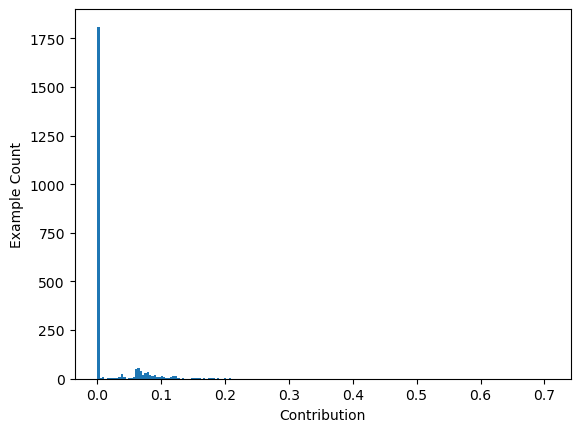

In [80]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score.item() if hasattr(result.score, 'item') else result.score for result in results]
#print(scores)
np.random.seed(42)

plt.hist(scores, density=False, bins=192)
plt.ylabel('Example Count')
plt.xlabel('Contribution')

In [81]:
b_scores = [s for s in scores if s > 0.01]
print(len(b_scores))

485


In [65]:
results.sort(key=operator.attrgetter('score'), reverse=True)
outliers = results[:6] # hardcoded first few N
outliers_per_iter.append(outliers)
target_nodes = [r.ablation_set[0] for r in outliers] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else
print(target_nodes)
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets) 

[Node(layer_idx=0, sequence_idx=0, attn_head_idx=10), Node(layer_idx=0, sequence_idx=0, attn_head_idx=1), Node(layer_idx=0, sequence_idx=0, attn_head_idx=0), Node(layer_idx=0, sequence_idx=0, attn_head_idx=7), Node(layer_idx=0, sequence_idx=0, attn_head_idx=3), Node(layer_idx=0, sequence_idx=0, attn_head_idx=9)]


TypeError: can only concatenate list (not "TargetNodeDecompositionList") to list

In [33]:
print(len(target_decomps))
print((abs(target_decomps[0].rels[0])))

2304
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')


## New algorithm (fixed number of nodes per layer, weight relevance to the nodes according to the nodes' relevance in the previous iter, take nodes with highest absolute scores)

There are two problems with this algorithm generally:

1. The "relevance to logits" score isn't on the same scale as "relevance to target nodes" score, so there's no principled way to decide whether nodes in the last layer are more or less relevant than others.

2. More fatally, the most important nodes converge to position 0.

In [22]:
import functools
ranges = [
        [11],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
# ablation_sets = [tuple(n for n in source_nodes)]
ablation_sets = [(n,) for n in source_nodes]

# print(source_nodes[:64])
target_nodes = []
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
# for each source node determine the contribution of rel to the actual score

logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
full_score = io_logit - s_logit
assert(full_score > 0)

last_layer_results = []
Result = collections.namedtuple('Result', ('ablation_set', 'score'))

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    #print(score, rel_io_logit, rel_s_logit)
    norm_score = score / full_score
    last_layer_results.append(Result(decomp.ablation_set, norm_score))


Running inputs 0 to 64 (of 192)
Running inputs 64 to 128 (of 192)
Running inputs 128 to 192 (of 192)


In [23]:
last_layer_results.sort(key=operator.attrgetter('score'), reverse=True)
last_layer_results[:6]

[Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=0),), score=0.0627064),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=6),), score=0.0623091),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=2),), score=0.049144655),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=3),), score=0.04818679),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=7),), score=0.04440797),
 Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=11),), score=0.0425904)]

In [24]:
last_layer_results.sort(key=operator.attrgetter('score'), reverse=True)
outliers = last_layer_results[:6] # hardcoded first few N
outliers_per_iter = [outliers]
node_weights = [r.score for r in outliers]

for layer in range(10, -1, -1):
    target_nodes = [r.ablation_set[0] for r in outliers] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else
    sum_scores = sum([r.score for r in outliers])
    node_weights = [r.score / sum_scores for r in outliers]
    print("layer %d: " % layer)
    print("new target nodes:")
    print(target_nodes)
    ranges = [
            [layer],
            [sequence_position for sequence_position in range(input_shape[1])],
            [attention_head_idx for attention_head_idx in range(12)]
        ]

    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes]

    prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    _, target_decomps = batch_run(prop_fn, ablation_sets) # why does this run so slowly? is it because moving target decomps is slow or something?

    results = []
    for target_decomp in target_decomps:
        # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
        score = 0
        for i in range(len(target_decomp.target_nodes)):
            weight = node_weights[i]
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score * weight)
        results.append(Result(target_decomp.ablation_set, score))
    results.sort(key=operator.attrgetter('score'), reverse=True)
    outliers = results[:6] # hardcoded first few N
    outliers_per_iter.append(outliers)


layer 10: 
new target nodes:
[Node(layer_idx=11, sequence_idx=14, attn_head_idx=0), Node(layer_idx=11, sequence_idx=14, attn_head_idx=6), Node(layer_idx=11, sequence_idx=14, attn_head_idx=2), Node(layer_idx=11, sequence_idx=14, attn_head_idx=3), Node(layer_idx=11, sequence_idx=14, attn_head_idx=7), Node(layer_idx=11, sequence_idx=14, attn_head_idx=11)]
Running inputs 0 to 64 (of 192)
Running inputs 64 to 128 (of 192)
Running inputs 128 to 192 (of 192)
layer 9: 
new target nodes:
[Node(layer_idx=10, sequence_idx=9, attn_head_idx=0), Node(layer_idx=10, sequence_idx=9, attn_head_idx=6), Node(layer_idx=10, sequence_idx=9, attn_head_idx=10), Node(layer_idx=10, sequence_idx=9, attn_head_idx=7), Node(layer_idx=10, sequence_idx=9, attn_head_idx=1), Node(layer_idx=10, sequence_idx=9, attn_head_idx=2)]
Running inputs 0 to 64 (of 192)
Running inputs 64 to 128 (of 192)
Running inputs 128 to 192 (of 192)
layer 8: 
new target nodes:
[Node(layer_idx=9, sequence_idx=2, attn_head_idx=0), Node(layer_idx

In [26]:
# for outs in outliers_per_iter:
#     print([r.score for r in outs])

all_outliers = sum(outliers_per_iter, [])
print(all_outliers[0])
print(len(all_outliers))

Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=0),), score=0.0627064)
72


In [27]:
all_outliers.sort(key=operator.attrgetter('score'), reverse=True)
for x in range(25):
    print(all_outliers[x])

Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=1),), score=tensor(0.0721, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=3),), score=tensor(0.0670, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=0),), score=0.0627064)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=6),), score=0.0623091)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=4),), score=tensor(0.0588, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=5),), score=tensor(0.0584, device='cuda:0'))
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=2),), score=0.049144655)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=3),), score=0.04818679)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx=7),), score=0.04440797)
Result(ablation_set=(Node(layer_idx=11, sequence_idx=14, attn_head_idx